In [1]:
# run this only once when you a zip file and when it is recycled
# from zipfile import ZipFile
# file_name = 'data_3.zip'

# with ZipFile(file_name,'r') as zip:
#   zip.extractall()
#   print('done')

done


In [2]:
# import the Libraries

import numpy as np  # numpy
import matplotlib.pyplot as plt  # plots for visualizationpath
import os  # for path folders
import pathlib
import glob

import cv2   # computer vision or OpenCv
import torch # PyTorch DeepLearning
from torchvision import transforms, datasets # laod data and transform to tensor
from torch.utils.data import DataLoader # for batch_size data
from torchvision.utils import make_grid

import torch.nn as nn  # MOdel
from torch import optim  # optimizer
from torchsummary import summary 

from torch.autograd import Variable
import torch.nn.functional as F  
from PIL import Image 

In [3]:
# checking for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
path ='data_3/'

In [5]:
# transforms
# to tranform the data to tensors  and Data Augumentation
train_transforms = transforms.Compose([transforms.Resize((256,256)),
                                       transforms.RandomCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,0.5,0.5],
                                                            [0.5,0.5,0.5])
                                       ])
test_transforms = transforms.Compose([ transforms.Resize((256,256)),
                                      transforms.RandomCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,0.5,0.5],
                                                            [0.5,0.5,0.5])
                                       ])

In [6]:
# Data for Train & Test
train_data = datasets.ImageFolder(path+'Train', transform=train_transforms)
test_data = datasets.ImageFolder(path+'Test', transform=test_transforms)

In [7]:
# Dataloader 
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:
# no of batches in train and Test
print(len(train_loader),len(test_loader)) # no of batches in the data no of iterations for each epoch (i)

14 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


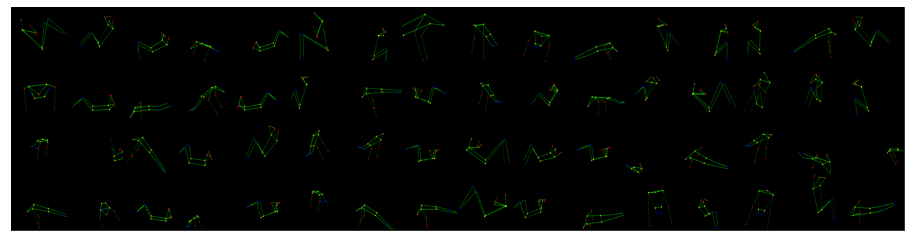

In [9]:

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
show_batch(train_loader)

In [10]:
# Tensoer images & labels
images, labels = next(iter(train_loader))
print(images.shape)
print(len(labels))

torch.Size([64, 3, 224, 224])
64


In [11]:
# classes
classes = sorted([j.name.split('/')[-1] for j in pathlib.Path(path+'Train').iterdir()])
classes_test = sorted([j.name.split('/')[-1] for j in pathlib.Path(path+'Test').iterdir()])
print(classes,classes_test)

['pushup', 'situp'] ['pushup', 'situp']


In [18]:
# Convolutional Neural Network (CNN) Module
class ConvNet(nn.Module):
  def __init__(self,num_classes=2):
    super(ConvNet, self).__init__()
    
    # First convolutional Layer

    # Output size after convolutional filter
    #(w-f+2p)/s +1 = 224-3+2*1 =224
    # input shape = 32,3,224,224 'batchsize,rgb colour, height , width of an image 

    self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
    # New Shape =(32,12,224,224)
    # Batch_Normalization no of features = no of out_channels
    self.bn1 =nn.BatchNorm2d(num_features=16)
    self.relu1 = nn.ReLU()
    #reduce the dimension of conv output by a factor of kernel size
    self.pool = nn.MaxPool2d(kernel_size=2)
    #new shape = (32,12,112,112)
    # Define proportion or neurons to dropout
    self.dropout = nn.Dropout(0.25)
    # second convoluitonal layer 
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
    # shape = (32,20,112,112)
    self.bn2 =nn.BatchNorm2d(num_features=32)
    self.relu2 = nn.ReLU()
    # self.pool = nn.MaxPool2d(kernel_size=2)
    #new shape = (32,20,56,56)
    # Third convoluitonal layer 
    self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
    # shape = (32,32,112,112)
    # Batch_Normalization no of features = no of out_channels
    self.bn3 =nn.BatchNorm2d(num_features=64)
    self.relu3 = nn.ReLU()
    
    # fully connected layer
    self.fc = nn.Linear(in_features=112 * 112 * 64,out_features=num_classes)
    
    #Forward Function
  def forward(self,input):
    output=self.conv1(input)
    output =self.bn1(output)
    output=self.relu1(output)
    output = self.dropout(output)
    output=self.pool(output)

    output=self.conv2(output)
    output =self.bn2(output)
    output=self.relu2(output)
    output = self.dropout(output)
    # output = self.pool(output)

    output=self.conv3(output)
    output =self.bn3(output)
    output=self.relu3(output)
    output = self.dropout(output)
      #Above output will be im matrix or tensor form with shape(32,32,112,112)for train for test(16,32,112,112)
      # reshape to feed in fc
    output=output.view(-1,64*112*112)  # flattern the data
    output =self.fc(output)

    return output


In [19]:
model = ConvNet(num_classes=2)
model

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=802816, out_features=2, bias=True)
)

In [21]:
# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

In [22]:
train_images_count = len(glob.glob(path+'Train'+'/**/*'))
test_images_count = len(glob.glob(path+'Test'+'/**/*'))
print(train_images_count, test_images_count)

848 201


In [24]:
# Model tarining and saving the best model
best_accuracy = 0
for epoch in range(19):
  # Evaluation and training on train_dataloader
  model.train()
  train_accuracy = 0
  train_loss = 0
  for i, (images,labels) in enumerate(train_loader):
    # if torch.cuda.is_available():
    #   images=Variable(images.cuda())
    #   labels = Variable(labels.cuda())
    optimizer.zero_grad() #to set gradient to zero for every batch

    outputs = model(images) # forward model
    loss = loss_function(outputs,labels) # computing loss
    loss.backward()  # loss propagation
    optimizer.step()  # updating weights and bias

    train_loss += loss.item()
    _,prediction = torch.max(outputs.data,1)

    train_accuracy += int(torch.sum(prediction==labels.data))

  train_accuracy = train_accuracy/train_images_count
  
  # Evaluation on test_dataloader
  with torch.no_grad():
    model.eval()
    test_loss = 0
    test_accuracy = 0
    for i, (images,labels) in enumerate(test_loader):

      outputs = model(images) # forward model
      loss = loss_function(outputs,labels) # computing loss
      test_loss += loss.item()
      _,prediction = torch.max(outputs.data,1)
      test_accuracy += int(torch.sum(prediction==labels.data))

    test_accuracy = test_accuracy/test_images_count

    if test_accuracy > best_accuracy:
      torch.save(model.state_dict(), 'Best_Pose_Model_7.pth') 
      best_accuracy=test_accuracy

  print('Epoch: '+ str(epoch) +' Train Loss: '+str(int(train_loss))+' Train_Accuracy: '+str(train_accuracy)+'Test Loss: '+str(int(test_loss))+' Test_Accuracy: '+str(test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 Train Loss: 376 Train_Accuracy: 0.5554245283018868Test Loss: 11 Test_Accuracy: 0.5024875621890548
Epoch: 1 Train Loss: 70 Train_Accuracy: 0.7806603773584906Test Loss: 5 Test_Accuracy: 0.7114427860696517
Epoch: 2 Train Loss: 37 Train_Accuracy: 0.8408018867924528Test Loss: 3 Test_Accuracy: 0.8805970149253731
Epoch: 3 Train Loss: 23 Train_Accuracy: 0.8667452830188679Test Loss: 30 Test_Accuracy: 0.5870646766169154
Epoch: 4 Train Loss: 27 Train_Accuracy: 0.8879716981132075Test Loss: 6 Test_Accuracy: 0.8855721393034826
Epoch: 5 Train Loss: 18 Train_Accuracy: 0.9162735849056604Test Loss: 5 Test_Accuracy: 0.8756218905472637
Epoch: 6 Train Loss: 12 Train_Accuracy: 0.9304245283018868Test Loss: 6 Test_Accuracy: 0.8507462686567164
Epoch: 7 Train Loss: 14 Train_Accuracy: 0.9162735849056604Test Loss: 2 Test_Accuracy: 0.9651741293532339
Epoch: 8 Train Loss: 7 Train_Accuracy: 0.9492924528301887Test Loss: 4 Test_Accuracy: 0.8905472636815921
Epoch: 9 Train Loss: 7 Train_Accuracy: 0.942216981132